Mount the google in the content

# Connect the drive

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


# built model (Used for creat predata)

In [ ]:
def create_model(myact, directory):
  chanDim = -1
  input_shape = (28, 28, 1)
  model_original = load_model(os.path.join(directory, "prenetwork/99.4_CNN.h5"))
  #model_original = load_model(CNN_weight_path)
  model = Sequential()
  # Layer 1 Conv2D
  cnn_layer = Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = input_shape)
  cnn_layer.trainable=False
  model.add(cnn_layer)
  cnn_layer2= Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False)
  cnn_layer2.trainable=False
  model.add(cnn_layer2)
  cnn_layer3=BatchNormalization()
  cnn_layer3.trainable=False
  model.add(cnn_layer3)
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = 2, strides = 2))
  model.add(Dropout(0.25))
  # Layer 3 Conv2D
  cnn_layer4= Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu')
  cnn_layer4.trainable=False
  model.add(cnn_layer4)
  cnn_layer5= Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False)
  cnn_layer5.trainable=False
  model.add(cnn_layer5)
  cnn_layer6= BatchNormalization()
  cnn_layer6.trainable=False
  model.add(cnn_layer6)
  # Layer 4 Pooling Layer
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = 2, strides = 2))
  model.add(Dropout(0.25))
  model.add(Flatten(name='flatten11'))

  model.add(Dense(1000, use_bias=False))
  model.add(Activation(myact))
  model.add(Dense(1000, use_bias=False))
  model.add(Activation(myact))

  model.add(Dense(10, activation='softmax', use_bias=False))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  model.layers[0].set_weights(model_original.layers[0].get_weights())
  model.layers[1].set_weights(model_original.layers[1].get_weights())
  model.layers[2].set_weights(model_original.layers[2].get_weights())
  model.layers[6].set_weights(model_original.layers[6].get_weights())
  model.layers[7].set_weights(model_original.layers[7].get_weights())
  model.layers[8].set_weights(model_original.layers[8].get_weights())
  return model

# Find intermediate layer output(Used for creat predata)



In [ ]:
# directory = ("/content/drive/MyDrive/PBCDcode/MNIST/data/")
# directory1 = os.path.join(directory, "prenetwork/99.4_CNN.h5")
# create_model = create_model(directory1)
# layer_name = 'flatten11'
# intermediate_layer_model = tf.keras.Model(inputs = create_model.input, outputs = create_model.get_layer(layer_name).output)

(x_train,y_train),(x_test,y_test) = datasets.mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# test_images = []
# for i in range(100):
#   test_0 = intermediate_layer_model(x_test[i*100:(i+1)*100,:,:])
#   if i ==0:
#     test_images = test_0.numpy().T
#   else:
#     test_images = np.hstack((test_images, test_0.numpy().T))

# train_images = []
# for i in range(600):
#   train_0 = intermediate_layer_model(x_train[i*100:(i+1)*100,:,:])
#   if i ==0:
#     train_images = train_0.numpy().T
#   else:
#     train_images = np.hstack((train_images, train_0.numpy().T))


# # train_images = train_images.numpy()
# # test_images = test_images.numpy()
directory = ("/content/drive/MyDrive/PBCDcode/MNIST/data/")
# np.save(os.path.join(directory, "rawdata/train_images.npy"), train_images.T)
# np.save(os.path.join(directory, "rawdata/test_images.npy"), test_images.T)
np.save(os.path.join(directory, "rawdata/train_labels.npy"), y_train)
np.save(os.path.join(directory, "rawdata/test_labels.npy"), y_test)


# Define some parameters, functions and models

In [2]:
import numpy as np   # science calculate  instill numpy

import struct  # y???????
from sklearn.utils import shuffle  # instill scikit-learn/ scikit
import time
import os  # o??????????
import scipy
from scipy import io
import torch as tc
import tensorflow as tf
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from tensorflow.keras import datasets
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,Activation,BatchNormalization,AveragePooling2D,MaxPooling2D
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
from tensorflow.keras.utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

def binary(x):
  return tf.maximum(-1.0, tf.minimum(1.0, x))
get_custom_objects().update({'binary': Activation(binary)})

from keras.layers import LeakyReLU
def Leakeyrelu(x):
    return tf.keras.layers.LeakyReLU(alpha=0.02)(x)
get_custom_objects().update({'Leakeyrelu': Activation(Leakeyrelu)})


def ccnn(x):
    # 自定义激活函数逻辑，例如 sigmoid
    return tf.sign(x * tf.cast(x >= 0, dtype=tf.float32))

def ccnn_derivative(x):
    # 计算自定义激活函数的导数
    x = x.numpy()
    tp = 0 * x + 0.4
    idex_row, idex_column = np.where( abs(x) <= 0.4 )
    idex0_row, idex0_column = np.where( abs(x) > 1 )
    if len(idex_row) > 0:
      tp[idex_row, idex_column] = 2 * tf.ones(len(idex_row)) - 4 * abs(x[idex_row, idex_column])
    if len(idex0_row) > 0:
      tp[idex0_row, idex0_column] = 0
    return tf.convert_to_tensor(tp, dtype = tf.float32)
get_custom_objects().update({'ccnn': Activation(ccnn)})


def pcnn(x):
    # 自定义激活函数逻辑，例如 sigmoid
    return 0.02 * tf.maximum(-1.0, tf.minimum(1.0, x))

def pcnn_derivative(x):
  x = x.numpy()
  tp = np.ones(x.shape)
  tp *= (x <= 1)
  tp *= (x >= -1)
  return tf.convert_to_tensor(tp, dtype = tf.float32)
get_custom_objects().update({'pcnn': Activation(pcnn)})

def bira(x):
    # 自定义激活函数逻辑，例如 sigmoid
    return tf.maximum(-1.0, tf.minimum(1.0, x))

def bira_derivative(x):
  x = x.numpy()
  x1 = x + 2
  x2 = x - 2
  x1 *= (x >= -1)
  x1 *= (x <= 0)

  x2 *= (x >= 0)
  x2 *= (x <= 1)

  return tf.convert_to_tensor(x1 + x2, dtype = tf.float32)
get_custom_objects().update({'bira': Activation(bira)})



def hardmax(x):  # 返回矩阵值 dimision: 10 * 64
    v1 = np.zeros(x.shape)
    v = np.argmax(x, 0)  # tf.argmax(a,1) 每一列最大值位置
    for i in range(x.shape[1]):
        v1[v[i], i] = 1
    return tf.convert_to_tensor(v1, dtype=tf.float32)

def forward_propagation(X, parameters):
    W1 = parameters["W1"]  # W1 维数 （784, 1000）
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    U1 = tf.matmul(tf.transpose(W1), X.T)  # + b1 * parameters['gamma1']
    # betch_size =16, nx*nx = 784 X为（784，16）, gamma1为nx*nx，X * gamma1的维数和X维数相同
    V1 = tf.sign(U1 + 1.e-10)  # 实现Relu，V1为 (1000，16)为第1隐层的值
    U2 = tf.matmul(tf.transpose(W2), V1)  # + b2    # W2^T 维数 （1000,1000） * parameters['gamma2']
    V2 = tf.sign(U2 + 1.e-10)  # 实现Relu，V2 (1000，16)为第2隐层的值
    U3 = tf.matmul(tf.transpose(W3), V2)  # + b3    # W3^T为 （10，1000） * parameters['gamma3']
    V3 = hardmax(U3)  # 输出 维数是10*batch 大小
    return tf.transpose(V3)

def costloss(V3, Y):
    cost = tf.square(tf.norm(V3 - Y)) / 2
    return cost

def errorloss(x_train, y_train, x_test, y_test, model_all):
    W1 = model_all.layers[0].get_weights()
    W1 = W1[0]
    W2 = model_all.layers[2].get_weights()
    W2 = W2[0]
    W3 = model_all.layers[4].get_weights()
    W3 = W3[0]
    parameters_in = { "W1": W1,
              "W2": W2,
              "W3": W3 }
    aa25 = forward_propagation(x_train, parameters_in)
    acc_train = (60000 - costloss(aa25, y_train))/60000
    aa25 = forward_propagation(x_test, parameters_in)
    acc_test = (10000 - costloss(aa25, y_test)) / 10000
    return acc_train, acc_test

def layer2_model(act_my):
  # chanDim = -1
  model = Sequential()
  model.add(Dense(1000, use_bias=False))
  model.add(Activation(act_my))
  model.add(Dense(1000, use_bias=False))
  model.add(Activation(act_my))

  model.add(Dense(10, activation='softmax', use_bias=False))
  model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
  return model

# Train process

In [ ]:
myacti = {0: "relu",
      1: "sigmoid",
      2: "swish",
      3: "selu",
      4: "tanh",
      5: "binary", # from 5, cpu acceleration
      6: "ccnn",
      7: "pcnn",
      8: "bira"
      }

directory0 = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/")
directorybase = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/activations")
if not os.path.exists(directorybase):
  os.makedirs(directorybase)
x_train = np.load(os.path.join(directory0, "rawdata/train_images.npy"))
x_test = np.load(os.path.join(directory0, "rawdata/test_images.npy"))
y_train = np.load(os.path.join(directory0, "rawdata/train_labels.npy"))
y_test = np.load(os.path.join(directory0, "rawdata/test_labels.npy"))

pre_N = 1
formal_N = 40
train_all_time = 5

for i in range(len(myacti)):
  if i == 6:
    historytrain_all = np.zeros((50, train_all_time))
    historytest_all = np.zeros((50, train_all_time))
    for tm in range(train_all_time):
      tf.random.set_seed(tm)
      historytrain = np.zeros((50, 1))
      historytest = np.zeros((50, 1))
      if i >= -6:  # decide what do I select Myacti
        model = layer2_model(myacti[i])
        if i >= 50:
          nu = 0
          for full in range(pre_N):
            history1 = model.fit(x_train, y_train, epochs= 1, batch_size = 128, validation_data=(x_test, y_test) )
            historytrain[nu], historytest[nu] = errorloss(x_train, y_train, x_test, y_test, model)
            nu += 1
          for formal in range(formal_N):
            history2 = model.fit(x_train, y_train, epochs= 1, batch_size = 256, validation_data=(x_test, y_test))
            historytrain[nu], historytest[nu] = errorloss(x_train, y_train, x_test, y_test, model)
            nu += 1
        else:
          history1 = model.fit(x_train, y_train, epochs= pre_N, batch_size = 128, validation_data=(x_test, y_test) )
          history2 = model.fit(x_train, y_train, epochs= formal_N, batch_size = 256, validation_data=(x_test, y_test))
          history_dict1 = history1.history
          history_dict2 = history2.history
          historytrain[0:pre_N+formal_N] = (np.append(np.array(history_dict1['accuracy']), np.array(history_dict2['accuracy']))).reshape(pre_N+formal_N,1)
          historytest[0:pre_N+formal_N] = (np.append(np.array(history_dict1['val_accuracy']), np.array(history_dict2['val_accuracy']))).reshape(pre_N+formal_N,1)

      historytrain_all[:, tm] = historytrain.reshape(50,)
      historytest_all[:, tm] = historytest.reshape(50,)
    directory = os.path.join(directorybase, myacti[i] + "network")
    directory_1 = os.path.join(directory, "historytrain_all"+'.npy')
    directory_2 = os.path.join(directory, "historytest_all"+'.npy')
    if not os.path.exists(directory):
      os.makedirs(directory)
    np.save(directory_1, historytrain_all)
    np.save(directory_2, historytest_all)

    print("========================================================")
    print("The current activation is: {},".format(myacti[i]))
    print("============Conduct New activation=====================")
    print("========================================================")




469/469 [==============================] - 13s 27ms/step - loss: 0.3031 - accuracy: 0.9349 - val_loss: 0.0873 - val_accuracy: 0.9811
Epoch 1/40
235/235 [==============================] - 9s 40ms/step - loss: 0.0777 - accuracy: 0.9823 - val_loss: 0.0686 - val_accuracy: 0.9827
Epoch 2/40
235/235 [==============================] - 8s 34ms/step - loss: 0.0615 - accuracy: 0.9852 - val_loss: 0.0596 - val_accuracy: 0.9848
Epoch 3/40
235/235 [==============================] - 10s 41ms/step - loss: 0.0519 - accuracy: 0.9869 - val_loss: 0.0534 - val_accuracy: 0.9854
Epoch 4/40
235/235 [==============================] - 11s 47ms/step - loss: 0.0451 - accuracy: 0.9886 - val_loss: 0.0511 - val_accuracy: 0.9854
Epoch 5/40
235/235 [==============================] - 7s 31ms/step - loss: 0.0403 - accuracy: 0.9901 - val_loss: 0.0462 - val_accuracy: 0.9868
Epoch 6/40
235/235 [==============================] - 10s 42ms/step - loss: 0.0364 - accuracy: 0.9912 - val_loss: 0.0436 - val_accuracy: 0.9871
Epoch 

# Show picture

0
1
2
3
4
5
6
7
8
9


<ipython-input-6-0f557c54c0d7>:54: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark')


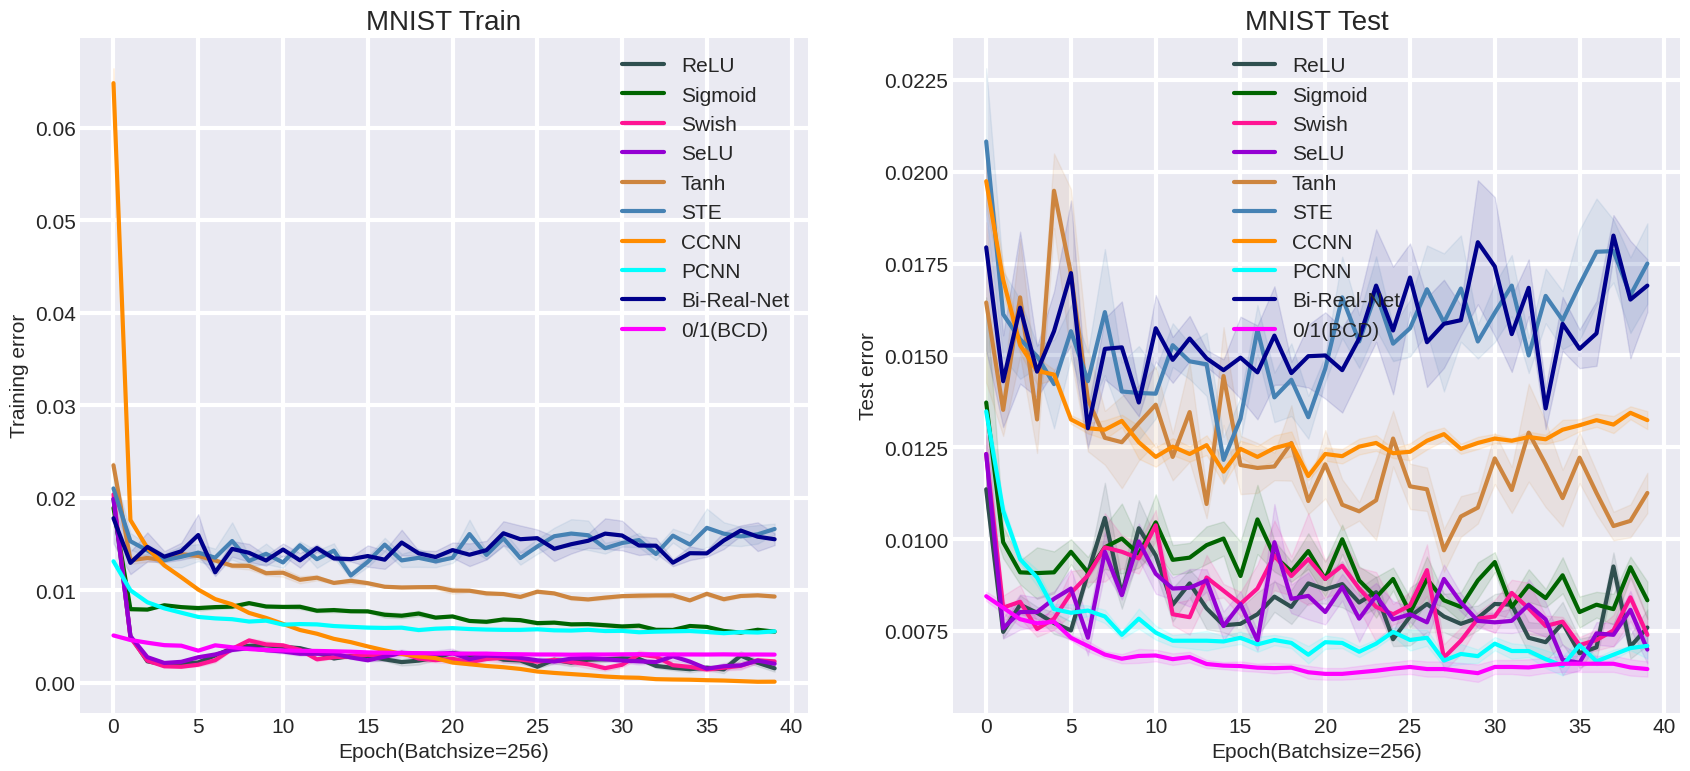

In [6]:
result_plot = {}
directorybase = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/activations")
myacti = {0: "relu",
      1: "sigmoid",
      2: "swish",
      3: "selu",
      4: "tanh",
      5: "binary",
      6: "ccnn",
      7: "pcnn",
      8: "bira",
      9: "01"}

Or_name = {0: "ReLU",
      1: "Sigmoid",
      2: "Swish",
      3: "SeLU",
      4: "Tanh",
      5: "STE",
      6: "CCNN",
      7: "PCNN",
      8: "Bi-Real-Net",
      9: "0/1(BCD)"}

color_all = {0: "darkslategrey",
        1: "darkgreen",
        2: "deeppink",
        3: "darkviolet",
        4: "peru",
        5: "steelblue",
        6: "darkorange",
        7: "cyan",
        8: "darkblue",
        9: "magenta"
       }

train_all_time = 5
plotN = 40
for i in range(len(myacti)):
  print(i)
  directory = os.path.join(directorybase, myacti[i] + "network")
  history_dict1 = np.load(os.path.join(directory, "historytrain_all"+'.npy'))
  history_dict2 = np.load(os.path.join(directory, "historytest_all"+'.npy'))
  history_dict1 = history_dict1[0:plotN,:]
  history_dict2 = history_dict2[0:plotN,:]
  result_plot[myacti[i] + "-mean-train"] = 1 - history_dict1.mean(axis=1)
  result_plot[myacti[i] + "-mean-test"] = 1 - history_dict2.mean(axis=1)
  result_plot[myacti[i] + "-std-train"] = np.linalg.norm(history_dict1-history_dict1.mean(axis=1)[:,None], axis = 1)/train_all_time
  result_plot[myacti[i] + "-std-test"] = np.linalg.norm(history_dict2-history_dict2.mean(axis=1)[:,None], axis = 1)/train_all_time

# Error avanrange picture
fig = plt.figure(figsize=(20,9))
plt.style.available
plt.style.use('seaborn-dark')
plt.subplots_adjust(left=0.1, bottom=0.15, right=0.9, top=0.9, hspace=0.2, wspace=0.2)

plt.subplot(1,2,1)
result_plot['epoch'] = range(plotN)

for act in range(len(myacti)): #
  plt.plot(result_plot['epoch'], result_plot[str(myacti[act])+'-mean-train'], c = color_all[act], alpha = 1, linewidth=3, label=Or_name[act])
  plt.fill_between(result_plot['epoch'],  result_plot[str(myacti[act])+'-mean-train']-result_plot[str(myacti[act])+'-std-train'], result_plot[str(myacti[act])+'-mean-train'] + result_plot[str(myacti[act])+'-std-train'], color=color_all[act], alpha=0.1)

plt.grid(lw=3)
plt.legend(fontsize=15)
plt.xlabel('Model settings',fontsize=15)

plt.xlabel('Epoch(Batchsize=256)',fontsize=15)
plt.ylabel('Training error',fontsize=15)
plt.title('MNIST Train',fontsize=20)
plt.tick_params(labelsize=15)

plt.subplot(1,2,2)

for act in range(len(myacti)): # len(myacti))
  plt.plot(result_plot['epoch'], result_plot[str(myacti[act])+'-mean-test'], c = color_all[act], alpha = 1, linewidth=3, label=Or_name[act])
  plt.fill_between(result_plot['epoch'],  result_plot[str(myacti[act])+'-mean-test']-result_plot[str(myacti[act])+'-std-test'], result_plot[str(myacti[act])+'-mean-test'] + result_plot[str(myacti[act])+'-std-test'], color=color_all[act], alpha=0.1)


plt.grid(lw=3)
plt.legend(fontsize=15)
plt.xlabel('Model settings',fontsize=15)

plt.xlabel('Epoch(Batchsize=256)',fontsize=15)
plt.ylabel('Test error',fontsize=15)
plt.title('MNIST Test',fontsize=20)
plt.tick_params(labelsize=15)

directoryf = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/result")
plt.savefig(os.path.join(directoryf, "MNIST_result_batchsize256.pdf"))
plt.show()

# print(history_test[7, 0:30])

In [ ]:
myacti = {0: "relu",
      1: "sigmoid",
      2: "swish",
      3: "selu",
      4: "tanh",
      5: "binary",
      6: "ccnn",
      7: "pcnn",
      8: "bira",
      9: "01"}
plotN = 40
for i in range(len(myacti)):
  print("=====================================")
  print(myacti[i])
  print(min(result_plot[myacti[i] + "-mean-train"]))
  print(min(result_plot[myacti[i] + "-mean-test"]))

relu
0.0014633417129517046
0.006900000572204634
sigmoid
0.005446672439575195
0.008000004291534468
swish
0.0014600038528442827
0.006780004501342751
selu
0.001546657085418679
0.006639993190765359
tanh
0.008923327922821023
0.009699988365173384
binary
0.01162000894546511
0.012160003185272217
ccnn
0.00013000965118403762
0.011720013618469194
pcnn
0.005383348464965798
0.0065600037574767844
bira
0.011959993839263938
0.013020014762878396
01
0.003060940225296016
0.006338334081344654


In [ ]:
needit = 1 # if need to save final results into final picture file
if needit: # had been finished
  directory = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/")
  historytrain_all = np.load(os.path.join(directory, "result/history1_all.npy"))
  historytest_all =  np.load(os.path.join(directory, "result/history2_all.npy"))
  #   # historytrain_all01204 = np.load(os.path.join(directory, "result/history1_all01204.npy"))
  #   # historytest_all01204 =  np.load(os.path.join(directory, "result/history2_all01204.npy"))
  #   # historytrain_all6015601 = np.load(os.path.join(directory, "result/history1_all6015601.npy"))
  #   # historytest_all6015601 =  np.load(os.path.join(directory, "result/history2_all6015601.npy"))
  #   # # directorybase = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/activations/01network")
  #   # # if not os.path.exists(directorybase):
  #   # #   os.makedirs(directorybase)
  #   # print(historytest_all)
  #   # print(historytest_all01204)
  #   # print(historytest_all6015601)
  #   # historytrain_all[:,0] = historytrain_all01204[:,2]
  #   # historytest_all[:,0] = historytest_all01204[:,2]
  #   # directory = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/")
  #   # np.save(os.path.join(directory, "result/history1_all.npy"), historytrain_all)
  #   # np.save(os.path.join(directory, "result/history2_all.npy"), historytest_all)
  directorybase = ("/content/drive/MyDrive/PBCDcode/MNIST_minibatch728/data/activations/01network")
  directory_1 = os.path.join(directorybase, "historytrain_all"+'.npy')
  directory_2 = os.path.join(directorybase, "historytest_all"+'.npy')
  np.save(directory_1, historytrain_all)
  np.save(directory_2, historytest_all)
  print(historytest_all)



[[0.98720002 0.98710001 0.9878     0.99010003 0.98710001]
 [0.98885    0.98950002 0.99004999 0.9912     0.98930001]
 [0.99049997 0.99190003 0.99229997 0.99229997 0.99150002]
 [0.99049997 0.99190003 0.99229997 0.99229997 0.99150002]
 [0.99070001 0.99199998 0.99239999 0.99260002 0.9914    ]
 [0.99070001 0.99199998 0.99239999 0.99260002 0.9914    ]
 [0.99089998 0.99190003 0.99250001 0.99260002 0.99150002]
 [0.99089998 0.99190003 0.99250001 0.99260002 0.99150002]
 [0.99040002 0.99220002 0.99309999 0.99290001 0.99169999]
 [0.99040002 0.99239999 0.99290001 0.99309999 0.99150002]
 [0.99080002 0.99250001 0.99290001 0.99309999 0.99150002]
 [0.99080002 0.99250001 0.99290001 0.99309999 0.99150002]
 [0.99119997 0.99269998 0.99299997 0.9932     0.99199998]
 [0.99119997 0.99269998 0.99299997 0.9932     0.99199998]
 [0.99119997 0.99269998 0.99299997 0.99330002 0.99199998]
 [0.99119997 0.99269998 0.99299997 0.99330002 0.99199998]
 [0.99119997 0.99269998 0.99309999 0.99330002 0.9921    ]
 [0.99119997 0

In [ ]:
directory = os.path.join(directorybase, myacti[6] + "network")
# history_dict1 = np.load(os.path.join(directory, "historytrain_all"+'.npy'))
history_dict2 = np.load(os.path.join(directory, "historytest_all"+'.npy'))
print(history_dict2)

[[0.99190003 0.99190003 0.99229997 0.99229997 0.99150002]
 [0.99190003 0.99190003 0.99229997 0.99229997 0.99150002]
 [0.99220002 0.99199998 0.99239999 0.99260002 0.9914    ]
 [0.99220002 0.99199998 0.99239999 0.99260002 0.9914    ]
 [0.99220002 0.99190003 0.99250001 0.99260002 0.99150002]
 [0.99220002 0.99190003 0.99250001 0.99260002 0.99150002]
 [0.99180001 0.99220002 0.99309999 0.99290001 0.99169999]
 [0.99190003 0.99239999 0.99290001 0.99309999 0.99150002]
 [0.99199998 0.99250001 0.99290001 0.99309999 0.99150002]
 [0.99199998 0.99250001 0.99290001 0.99309999 0.99150002]
 [0.99229997 0.99269998 0.99299997 0.9932     0.99199998]
 [0.99229997 0.99269998 0.99299997 0.9932     0.99199998]
 [0.99250001 0.99269998 0.99299997 0.99330002 0.99199998]
 [0.99250001 0.99269998 0.99299997 0.99330002 0.99199998]
 [0.99260002 0.99269998 0.99309999 0.99330002 0.9921    ]
 [0.99260002 0.99269998 0.99309999 0.99330002 0.9921    ]
 [0.99269998 0.99260002 0.9932     0.99349999 0.99229997]
 [0.99269998 0

# Old drawing code

In [ ]:
print(i, len(c1))
myacti_show = {0: "ReLU",
      1: "Sigmoid",
      2: "Swish",
      3: "SELU",
      4: "Tanh",
      5: "-1/1(STE)",
      6: "0/1(BCD)"}

for i in range(0,len(myacti_show)):
  plt.plot(1-history_train[i, 0:35], label= str(myacti_show[i]))
  print(history_train[i, 35], np.min(1-history_train[i, 35]))
  plt.xlabel('Epoch')
  plt.ylabel('Train error')
  plt.ylim([0, 0.045])
  plt.legend(loc='upper right')
plt.savefig(os.path.join(directorybase, "trainacc.pdf"))
plt.show()
# # plt.savefig()
# print(history_train[7, 0:30])

for i in range(0,len(myacti_show)): # in range(8):
  plt.plot(1-history_test[i, 0:35], label= str(myacti_show[i]))
  plt.xlabel('Epoch')
  plt.ylabel('Test error')
  plt.ylim([0.0000, 0.035])
  plt.legend(loc='upper right')
  print(history_test[i, 35], np.min(1-history_test[i, 35]))

In [ ]:
from locale import ABDAY_3
myacti = {0: "relu",
      1: "sigmoid",
      2: "swish",
      3: "selu",
      4: "tanh",
      5: "binary",
      6: "01"}
A0 = np.matrix([[0.98,0.9903,0.9901,0.9899,0.9901,0.9906,0.9912,0.992,0.9927,0.9933,0.9936,0.9939,0.9943,0.9944,0.9947,0.9949,0.9951,0.9955,0.9957,0.9959,0.996,0.9962,0.9964,0.9965,0.9966,0.9969,0.997,0.9971,0.9971,0.9973,0.9973,0.9974,0.9975,0.9975,0.9975,0.9976,0.9976,0.9977,0.9977,0.9978,0.9979,0.9807,0.9891,0.9886,0.9887,0.9894,0.9898,0.9903,0.9909,0.9914,0.9919,0.9924,0.993,0.9935,0.9939,0.9943,0.9948,0.9952,0.9954,0.9957,0.9961,0.9964,0.9966,0.9967,0.9969,0.9969,0.997,0.997,0.9971,0.9971,0.9971,0.9972,0.9973,0.9973,0.9974,0.9975,0.9975,0.9976,0.9977,0.9977,0.9977,0.9977,0.9797,0.9874,0.9872,0.9871,0.9879,0.989,0.9899,0.9906,0.9914,0.9921,0.9927,0.9934,0.9942,0.9947,0.9953,0.9955,0.9959,0.9962,0.9965,0.9967,0.9969,0.9969,0.997,0.9971,0.9972,0.9972,0.9972,0.9973,0.9973,0.9974,0.9974,0.9975,0.9975,0.9976,0.9977,0.9978,0.998,0.998,0.998,0.998,0.9981,0.9798,0.993,0.993,0.9931,0.9933,0.9936,0.9941,0.9944,0.9947,0.9948,0.9952,0.9952,0.9953,0.9955,0.9955,0.9957,0.9958,0.9959,0.996,0.9961,0.9962,0.9963,0.9964,0.9964,0.9965,0.9967,0.9967,0.9967,0.9969,0.997,0.9971,0.9972,0.9972,0.9972,0.9973,0.9974,0.9975,0.9976,0.9977,0.9977,0.9978,0.9792,0.99,0.9904,0.9905,0.9907,0.991,0.9915,0.992,0.9923,0.9928,0.9931,0.9936,0.9939,0.9941,0.9945,0.9947,0.995,0.9952,0.9955,0.9956,0.9958,0.9959,0.996,0.9961,0.9963,0.9964,0.9965,0.9966,0.9967,0.9968,0.9968,0.9969,0.997,0.9971,0.9972,0.9972,0.9973,0.9973,0.9974,0.9975,0.9976,0.9721,0.9833,0.9803,0.9795,0.9801,0.9842,0.9873,0.9876,0.9865,0.9856,0.9864,0.9883,0.9896,0.9907,0.9912,0.9912,0.9909,0.9907,0.9909,0.9914,0.9918,0.9924,0.9924,0.9929,0.9932,0.9934,0.9937,0.9938,0.994,0.994,0.9939,0.994,0.9944,0.9944,0.9945,0.9947,0.9948,0.9949,0.9949,0.9951,0.9952,0.9725,0.9856,0.9865,0.9842,0.9829,0.9864,0.9888,0.9897,0.9895,0.9886,0.9881,0.9889,0.9901,0.9913,0.9918,0.9922,0.9921,0.9921,0.9923,0.9923,0.9928,0.9931,0.9933,0.9936,0.9937,0.9937,0.9938,0.9941,0.9942,0.9945,0.9946,0.9946,0.9947,0.9947,0.9948,0.9949,0.995,0.9952,0.9952,0.9952,0.9952,0.9723,0.9766,0.9728,0.9763,0.9817,0.9864,0.9858,0.9833,0.9826,0.9857,0.9887,0.9898,0.9895,0.9891,0.9893,0.9895,0.9904,0.9907,0.9912,0.9917,0.9921,0.9926,0.9931,0.9932,0.9933,0.9935,0.9935,0.9936,0.9937,0.9941,0.9946,0.9947,0.9947,0.9948,0.9949,0.9949,0.9949,0.995,0.9952,0.9952,0.9954,0.9728,0.986,0.9873,0.985,0.9852,0.9865,0.9879,0.9887,0.9885,0.9879,0.9882,0.9894,0.9902,0.991,0.9916,0.992,0.992,0.9923,0.9925,0.9927,0.9931,0.9931,0.9933,0.9934,0.9937,0.9938,0.9939,0.9943,0.9942,0.9945,0.9945,0.9946,0.9948,0.9949,0.9951,0.9953,0.9954,0.9955,0.9956,0.9956,0.9956,0.973,0.9698,0.9776,0.9779,0.9784,0.9807,0.9806,0.9831,0.985,0.9854,0.9855,0.9873,0.9886,0.9896,0.9898,0.9895,0.9892,0.9898,0.9911,0.992,0.9922,0.9925,0.9924,0.9925,0.9927,0.9928,0.993,0.9933,0.9933,0.9936,0.9938,0.9941,0.9945,0.9948,0.9948,0.9949,0.9949,0.995,0.995,0.9951,0.9953,]])
A3 = A0[:,0:205]
A4 = A0[:,205:410]
print(A3.shape, A4.shape)
his_train = A4.reshape(5,41)
his_train = his_train.T
historytrain_all = np.zeros((50, train_all_time))
historytrain_all[0:41,:] = his_train
directory = os.path.join(directorybase, myacti[4] + "network")
history_dict2 = os.path.join(directory, "historytrain_all"+'.npy')
np.save(history_dict2, historytrain_all)

# print(his_train)

(1, 205) (1, 205)
